## PLANS AND TODO:

Analysis for all things labelled

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import myFunctions as mf
import importlib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [79]:
importlib.reload(mf)

<module 'myFunctions' from '/home/jovyan/Pstat134/Final Project/BasketballPlayoffs/myFunctions.py'>

In [80]:
plyrs = pickle.load(open( "allplayers.p", "rb" ))
plyrsreg = pickle.load(open("allplayersregular.p","rb"))
PIDS = [i for i in plyrs.keys()]


## Regular Season vs Playoffs

In [81]:
# Create DataFrames will all shot data from regular season and playoffs
shots =  []
for i in PIDS:
    if(len(plyrsreg[i].index) < 50 or len(plyrs[i].index) < 15):
        continue # Skip players who did not take over 100 shots during regular season
    shots.append(plyrsreg[i])
    tmp = plyrs[i]
    tmp['PLAYER_ID'] *= -1 #to separate playoffs from regular. Easy to convert back to
    shots.append(tmp)
allshots = pd.concat(shots,ignore_index = True)


In [82]:
# Create smoothed bins of shots for all players
xedges = np.linspace(start=-300, stop=300, num=151)
yedges = np.linspace(start=-48, stop=372, num=106)
bin_edges = (xedges, yedges)

nx = xedges.size - 1
ny = yedges.size - 1
player_dict = {}
FPIDS = []
all_smooth = []
for i in enumerate(allshots.groupby('PLAYER_ID')):
    tmp, xedges, yedges = mf.bin_shots(i[1][1], bin_edges=(xedges, yedges), density=True, sigma=2) #i[1][1] is df
    ## vectorize and store into list
    all_smooth += [tmp.reshape(-1)]
    FPIDS.append(i[1][1].PLAYER_ID.iloc[0])
    #FPIDS.append(-i[1][1].PLAYER_ID.iloc[0])
    player_dict[i[1][1].PLAYER_ID.iloc[0]] = i[1][1].PLAYER_NAME.iloc[0]
X = np.vstack(all_smooth).T
p,n = X.shape
print(p,n) # n is number of players, p is shot regions

15750 22


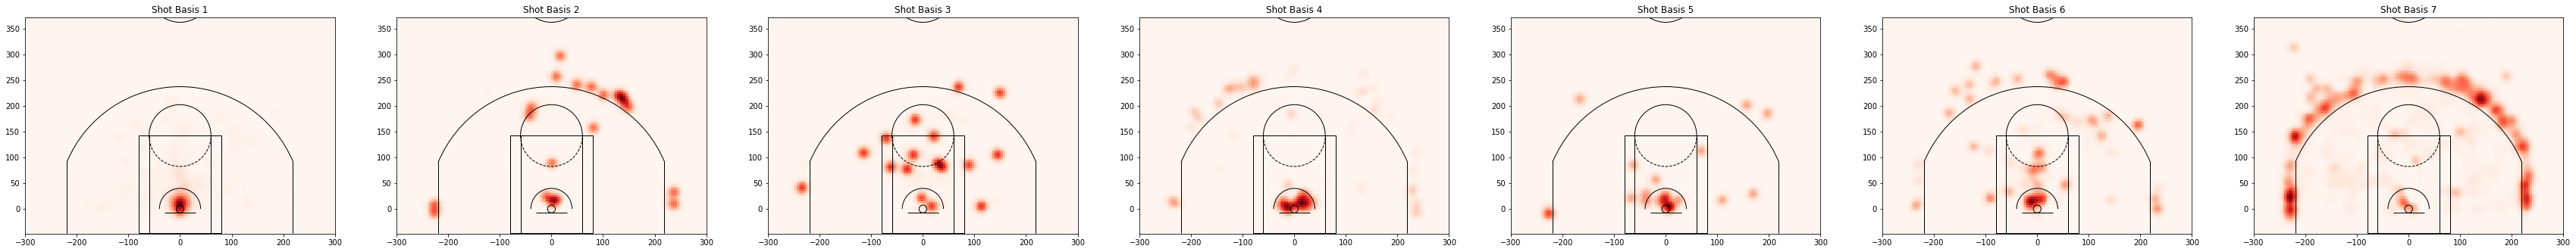

In [83]:
W,H = mf.non_negative_marix_decomp(7,X)
fig, ax = plt.subplots(1, 7, figsize=(60,20))
## Write a for loop
for i in range(7):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))

We see there is a nice variety within the bases. Lets see what kind of insight the coefficients can provide

In [84]:
comp = []
for i in range(len(FPIDS)):
    comp.append([H[:,i].round(3)])
comp = pd.DataFrame(index = FPIDS, data = comp)


indices = []
rows = []
for i in FPIDS:
    if(i < 0):
        continue
    #print("Player Name:",player_dict[i])
    #print("Shots Taken Regular Season:",len(plyrsreg[i].index))
    #print("Shots Taken Playoffs:",len(plyrs[i].index))
    #print(comp.loc[i][0])
    #print(comp.loc[-i][0])
    indices.append(player_dict[i])
    rows.append(comp.loc[-i][0] - comp.loc[i][0])
compare = pd.DataFrame(data = rows,index = indices, columns = ["SHOTBASIS" + str(i) for i in range(1,8)])

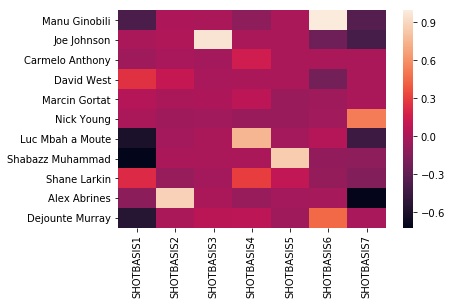

In [86]:
sns.heatmap(compare)
plt.show()

### Analysis

Above is a plot of the difference between a players NMF coefficient for playoffs and regular season. 

## Individual Shot Selecti between different quarters

In [87]:
# Create DataFrames will all shot data from regular season
shots =  []
tmp = []
flag = True
for i in PIDS:
    for j in range(4):
        if(len(plyrsreg[i].PERIOD.value_counts()) < 4  or plyrsreg[i].PERIOD.value_counts().iloc[j] < 2):
            flag = False
    if flag:
        temp = plyrsreg[i].copy()
        temp.drop(temp.index[temp.PERIOD>4],inplace = True) # To remove data that goes into overtime
        shots.append(temp)
    flag = True
periodShots = pd.concat(shots,ignore_index = True)

In [88]:
player_dict = {}
FPIDS = []
FPIDSloop = []
player_name = []
period = []
numShots = {}
all_smooth = []
for i in enumerate(periodShots.groupby(['PLAYER_ID','PERIOD'])):
    temp = i[1][1]
    #temp.drop([temp.PERIOD > 4])
    tmp, xedges, yedges = mf.bin_shots(temp, bin_edges=(xedges, yedges), density=True, sigma=2) #i[1][1] is df
    ## vectorize and store into list
    all_smooth += [tmp.reshape(-1)]
    if(temp.PLAYER_ID.iloc[0] not in FPIDS):
        FPIDS.append(temp.PLAYER_ID.iloc[0])
        player_dict[temp.PLAYER_ID.iloc[0]] = temp.PLAYER_NAME.iloc[0]
        numShots[temp.PLAYER_ID.iloc[0]] = []
    player_name.append(temp.PLAYER_NAME.iloc[0])
    FPIDSloop.append(temp.PLAYER_ID.iloc[0])
    period.append(temp.PERIOD.iloc[0])
    numShots[temp.PLAYER_ID.iloc[0]].append(len(i[1][1]))
X = np.vstack(all_smooth).T
p,n = X.shape
print(p,n) # n is number of players, p is shot regions

15750 400


In [89]:
n = 7
W,H = mf.non_negative_marix_decomp(n,X)

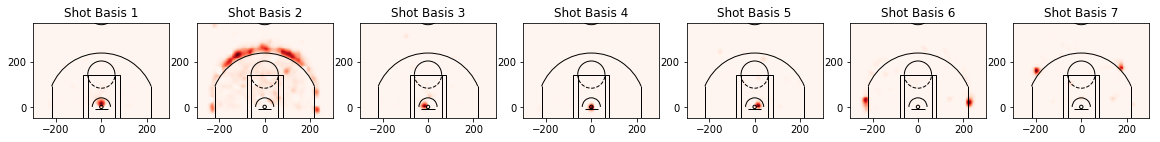

In [90]:
fig, ax = plt.subplots(1, n, figsize=(20,60))
## Write a for loop
for i in range(n):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))


This appears to be a basic but well encompasing set of bases for standard shot styles. While it may appear close shots have an over representation, each of the close bases represent different shots (Shot from Center, left side layup, dunk, right sude layup)

In [50]:
comprounded = []
for i in range(len(FPIDSloop)):
    comprounded.append([H[:,i].round(3)][0])
comprounded = pd.DataFrame(index = [player_name,period], data = comprounded, columns = ["SHOTBASIS" + str(i) for i in range(1,8)])

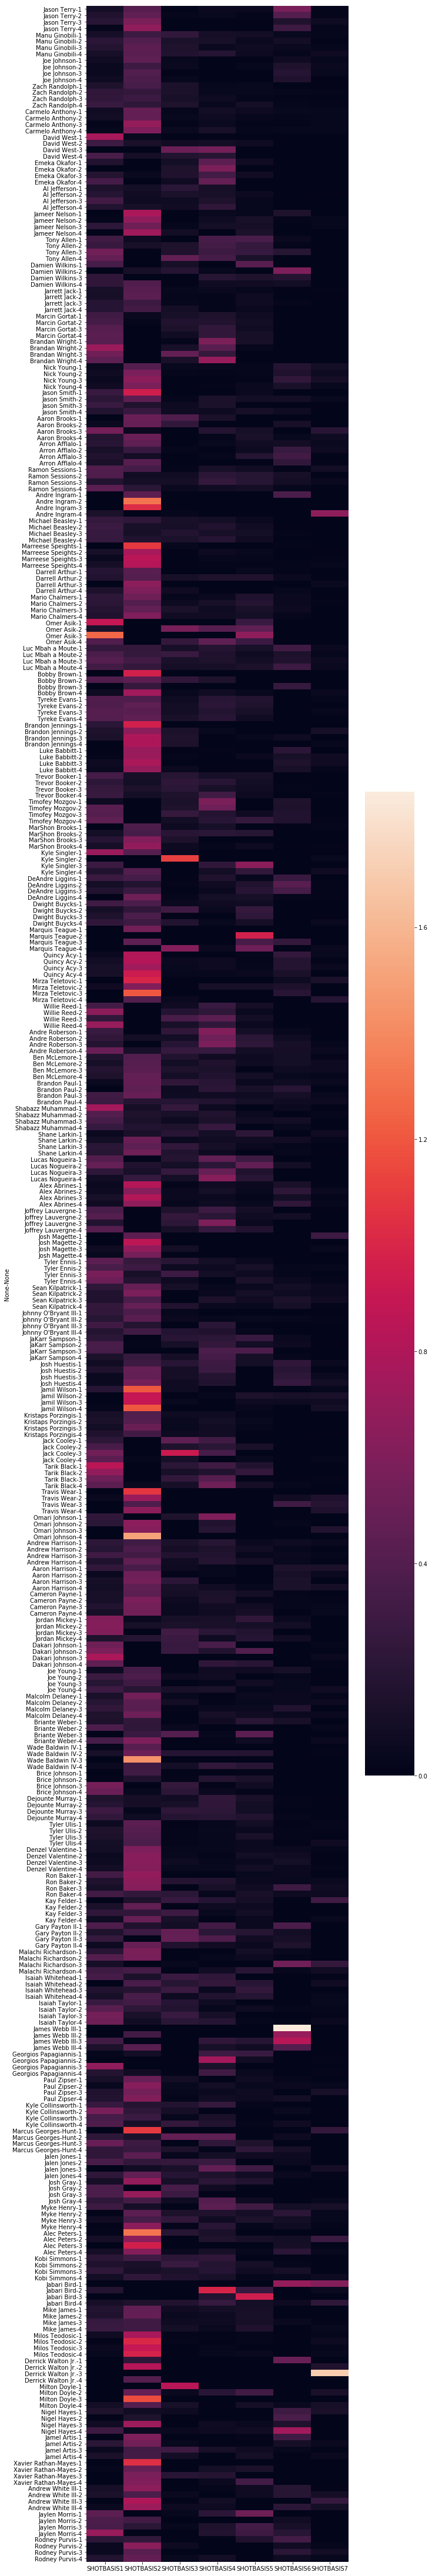

In [55]:
plt.figure(figsize = (10,80))
sns.heatmap(comprounded)
plt.show()

interactive(children=(Dropdown(description='Player:', options=('Aaron Brooks', 'Aaron Harrison', 'Al Jefferson…

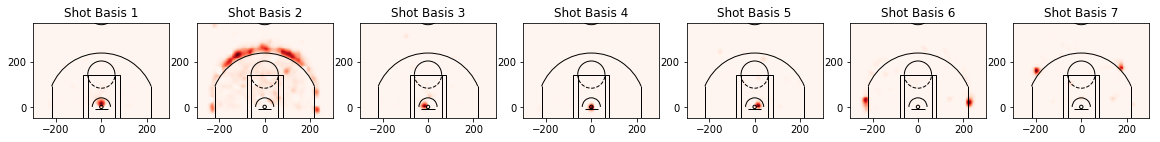

In [117]:
def plotHeat(df,player):
    sns.heatmap(df.loc[player])
    plt.title(player + "'s Shot Selection By Period")
    plt.show()
    
interact(plotHeat,df = fixed(comprounded), player = widgets.Dropdown(
    options=comprounded.index.levels[0].values,
    description='Player:',
    disabled=False,
))
fig, ax = plt.subplots(1, n, figsize=(20,60))
for i in range(n):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))
plt.show()

In [ ]:
One common trend we notice is that many players have a big increase in the bases corresponding to 3 point shots toward the end of the game.

INCLUDE MORE

## Period Analysis

### Comparing Bases for all players between periods

The heatmap of period coefficients is large and difficult to analyze, however we can simply compare the bases of NMF between each of the periods for all shooters.



In [61]:
# Redoing this so we can include overtime
shots =  []
tmp = []
for i in PIDS:
    temp = plyrsreg[i].copy()
    shots.append(temp)
periodShots = pd.concat(shots,ignore_index = True)

In [65]:
per1 = []
per2 = []
per3 = []
per4 = []
per5 = []
for i in enumerate(periodShots.groupby(['PLAYER_ID','PERIOD'])):
    temp = i[1][1]
    if len(temp) < 2 :
        continue
    tmp, xedges, yedges = mf.bin_shots(temp, bin_edges=(xedges, yedges), density=True, sigma=2) #i[1][1] is df
    ## vectorize and store into list
    if temp.PERIOD.iloc[0] == 1:
        per1 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 2:
        per2 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 3:
        per3 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 4:
        per4 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 5:
        per5 += [tmp.reshape(-1)]
X1 = np.vstack(per1).T
X2 = np.vstack(per2).T
X3 = np.vstack(per3).T
X4 = np.vstack(per4).T
X5 = np.vstack(per5).T

print(X1.shape) # n is number of players, p is shot regions
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(X5.shape)

(15750, 113)
(15750, 116)
(15750, 106)
(15750, 147)
(15750, 16)


In [66]:
n = 7
W1,H1 = mf.non_negative_marix_decomp(n,X1)
W2,H2 = mf.non_negative_marix_decomp(n,X2)
W3,H3 = mf.non_negative_marix_decomp(n,X3)
W4,H4 = mf.non_negative_marix_decomp(n,X4)
W5,H5 = mf.non_negative_marix_decomp(n,X5)

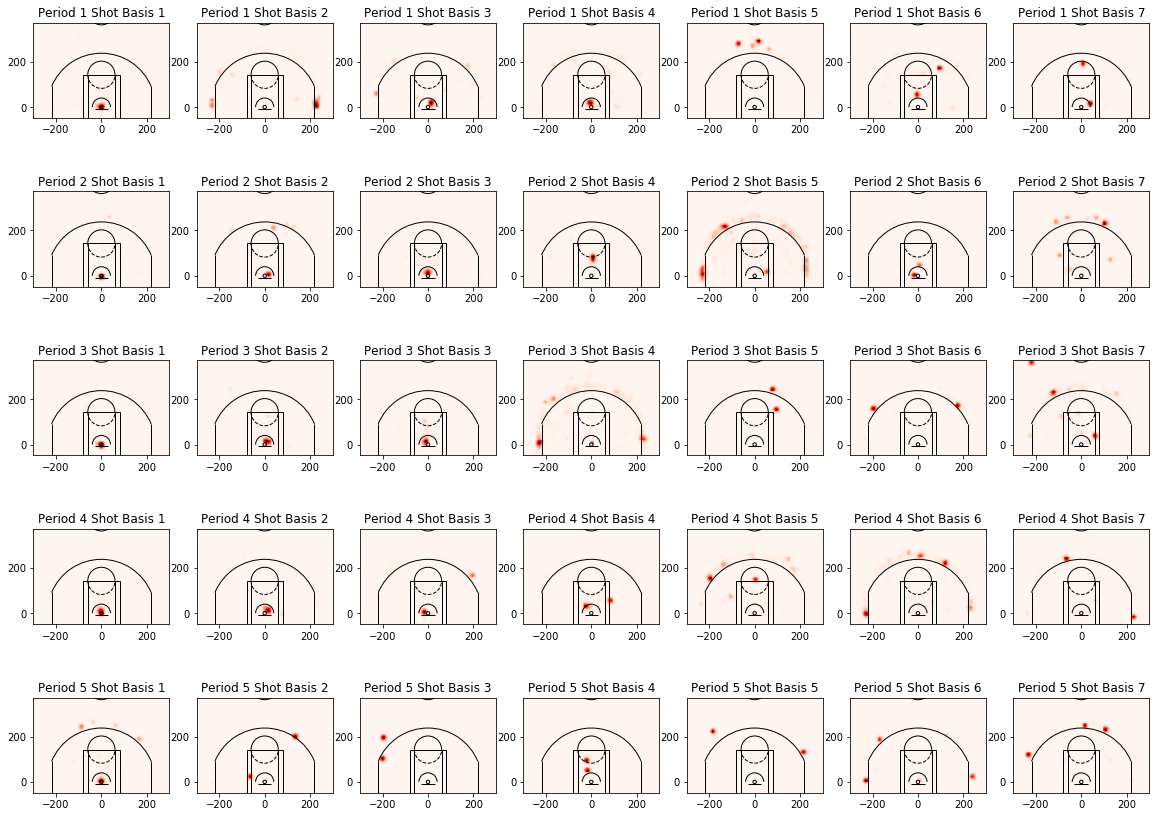

In [76]:
fig, ax = plt.subplots(5, n, figsize=(20,15))
## Write a for loop
for i in range(n):
    mf.plot_vectorized_shotchart(W1[:,i],xedges,yedges,ax = ax[0,i])
    ax[0,i].set_title('Period 1 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W2[:,i],xedges,yedges,ax = ax[1,i])
    ax[1,i].set_title('Period 2 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W3[:,i],xedges,yedges,ax = ax[2,i])
    ax[2,i].set_title('Period 3 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W4[:,i],xedges,yedges,ax = ax[3,i])
    ax[3,i].set_title('Period 4 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W5[:,i],xedges,yedges,ax = ax[4,i])
    ax[4,i].set_title('Period 5 Shot Basis %i' % (i+1))

## General Period Analysis

Period 1:
From the Period Shot Basis analysis I notice that the most common three point shots taken are the corner threes and straight up three in the first period. Both of these threes have the highest points per possesion (read here: https://www.82games.com/locations.htm), which leads me to believe teams may use these higher percentage shots more extensively early on to warm up their players. Other than these threes, the majority of shots are taken within 5 feet of the rim, with very few midrange.

Period 2:
Shots taken on the perimeter spread out much more in the second period; with corner, wing, and straight up threes being taken. With players warmed up from the previous period, we can expect to see more three point shot types to show up. besides threes, the majority of shots are still taken close to the rim, with a small amount of spreading to the midrange.

Period 3:
During the third period we start to see a significant amount of midrange shots being taken. This may be attributed to teams having the opportunity to adjust defensively during the halftime and force less efficient shot.

Period 4:
With players tiring out by the fourth period its no surprise a higher percentage of shots are taken at the three point line. As the game nears the end, teams focus more on the higher efficiency shots and move away from the midrange

Period 5:
Since most games do not go into overtime we likely don't have very useful information, which is why most of the shots appear as solid points on the basis chart.